In [1]:
#@title Install libraries and Import modules
#!pip install sklearn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score, f1_score, cohen_kappa_score, accuracy_score, balanced_accuracy_score, recall_score, precision_score, balanced_accuracy_score, make_scorer, matthews_corrcoef, plot_confusion_matrix

from sklearn.feature_selection import VarianceThreshold, SelectFromModel

from sklearn.metrics import confusion_matrix
from sklearn import metrics

from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder

from statsmodels.stats.multitest import multipletests

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#@title Downloading radiomics files

#@markdown We will now download 2 files: a file containing the radiomic features
#@markdown and anoter file containing the corresponding labels.

!wget --max-redirect=20 -O prostateX_T2WAx.csv https://www.dropbox.com/s/5apip8cs6gtm15b/prostateX_T2WAx_clean.csv?dl=1
!wget --max-redirect=20 -O prostateX_T2WAx_labels.csv https://www.dropbox.com/s/cfva869027a9j2i/ProstateX-ClinSig-Train_PatientLevel.csv?dl=1

--2021-03-18 11:00:02--  https://www.dropbox.com/s/5apip8cs6gtm15b/prostateX_T2WAx_clean.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/5apip8cs6gtm15b/prostateX_T2WAx_clean.csv [following]
--2021-03-18 11:00:03--  https://www.dropbox.com/s/dl/5apip8cs6gtm15b/prostateX_T2WAx_clean.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc67634981a4af81850de5b1f1c8.dl.dropboxusercontent.com/cd/0/get/BK4h2BaleePkZT7L92dc-n0CEyude64iZ3Y9DZK4YxHm5I_8pywsoXOW-5kc1e-DpKZYFu44fXHob55GZVxKhuyNfV1W7_Gk_3JkU5eiQzQ7N9ygF4N3P-GYjEBwLK4kbIcQc_nLDyEhvw9Zm2QW3W0s/file?dl=1# [following]
--2021-03-18 11:00:03--  https://uc67634981a4af81850de5b1f1c8.dl.dropboxusercontent.com/cd/0/get/BK4h2BaleePkZT7L92dc-n0CEyude64iZ3Y9DZK4YxHm5I_8p

In [3]:
#@title Load radiomic features and corresponding labels
features_df = pd.read_csv('prostateX_T2WAx.csv')#, index_col=0
outcome_df = pd.read_csv('prostateX_T2WAx_labels.csv')#, index_col=0
features_df.head()
outcome_df.head()
indx_features = pd.Index(features_df.ID)
indx_outcomes = pd.Index(outcome_df.ProxID)
indx_used_patients = indx_features.intersection(indx_outcomes).to_list()

features_df = features_df.set_index('ID')
outcome_df = outcome_df.set_index('ProxID')

X = features_df.loc[indx_used_patients]
Y = outcome_df.loc[indx_used_patients,'ClinSig']
print("Labels:")
print(Y.head())
print("")
print("Radiomic Features:")
X.head()

Labels:
ProxID
Prostatex0173    False
Prostatex0110    False
Prostatex0046     True
Prostatex0028     True
Prostatex0080    False
Name: ClinSig, dtype: bool

Radiomic Features:


,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,...,exponential_glrlm_RunPercentage,exponential_glrlm_RunVariance,exponential_glrlm_ShortRunEmphasis,exponential_glrlm_ShortRunHighGrayLevelEmphasis,exponential_glrlm_ShortRunLowGrayLevelEmphasis,exponential_glszm_GrayLevelNonUniformity,exponential_glszm_GrayLevelNonUniformityNormalized,exponential_glszm_GrayLevelVariance,exponential_glszm_HighGrayLevelZoneEmphasis,exponential_glszm_LargeAreaEmphasis,exponential_glszm_LargeAreaHighGrayLevelEmphasis,exponential_glszm_LargeAreaLowGrayLevelEmphasis,exponential_glszm_LowGrayLevelZoneEmphasis,exponential_glszm_SizeZoneNonUniformity,exponential_glszm_SizeZoneNonUniformityNormalized,exponential_glszm_SmallAreaEmphasis,exponential_glszm_SmallAreaHighGrayLevelEmphasis,exponential_glszm_SmallAreaLowGrayLevelEmphasis,exponential_glszm_ZoneEntropy,exponential_glszm_ZonePercentage,exponential_glszm_ZoneVariance,exponential_ngtdm_Busyness,exponential_ngtdm_Coarseness,exponential_ngtdm_Complexity,exponential_ngtdm_Contrast,exponential_ngtdm_Strength,exponential_gldm_DependenceEntropy,exponential_gldm_DependenceNonUniformity,exponential_gldm_DependenceNonUniformityNormalized,exponential_gldm_DependenceVariance,exponential_gldm_GrayLevelNonUniformity,exponential_gldm_GrayLevelVariance,exponential_gldm_HighGrayLevelEmphasis,exponential_gldm_LargeDependenceEmphasis,exponential_gldm_LargeDependenceHighGrayLevelEmphasis,exponential_gldm_LargeDependenceLowGrayLevelEmphasis,exponential_gldm_LowGrayLevelEmphasis,exponential_gldm_SmallDependenceEmphasis,exponential_gldm_SmallDependenceHighGrayLevelEmphasis,exponential_gldm_SmallDependenceLowGrayLevelEmphasis
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Prostatex0173,0.802961,0.751488,38.005547,50.573715,57.998625,52.200010,54.560425,58.443823,54065.406484,40.608697,0.751463,9201.453205,0.170191,54138.261513,-42.395067,113.921884,5.561117e+09,4.672031,76.657842,2.900002,206.963146,46.676979,28.332475,20.988417,-111.936396,318.899542,32.441580,333.523473,0.577807,6.006008e+09,0.045142,3435.692665,312.227142,72870.120613,1173.233264,157.219620,9.109830,0.890374,2.229544,2.737708,...,0.065924,400.113993,0.357406,1.766200,0.129420,150.167883,0.365372,0.651109,6.038929,4.295851e+05,4.319972e+05,4.290420e+05,0.289572,92.975669,0.226218,0.487558,3.348981,0.130521,4.719206,0.008221,4.147895e+05,152.438606,0.001145,0.319646,0.000714,0.012686,1.346827,34376.195447,0.687620,1.888559,43998.552457,0.100547,1.260456,73.673614,80.946733,72.133298,0.950714,0.020808,0.059645,0.015144
Prostatex0110,0.861237,0.824158,42.907764,52.062539,58.060659,52.680552,60.908128,61.478777,71098.076301,44.838174,0.756145,10976.177733,0.154381,71193.611316,-76.843521,123.690081,6.487170e+09,4.932813,104.943558,2.601579,233.520423,61.287834

In [4]:
#@title Split Data

#@markdown We will start by splitting the data into 2 separate sets.

#@markdown 1. Training dataset
#@markdown 2. Held-out test dataset

#@markdown the training dataset will be used for the selection of the classifier
#@markdown algorithm we will use and its fine-tuning, while the held-out test
#@markdown dataset will be used to validade the model and assess its performance
#@markdown on unseen data.

#@markdown The percentage of data used for the held-out test datased is set to 
#@markdown 30% (0.3) but you can change it in the slider below.
test_prcntg = 0.3 #@param {type:"slider", min:0.1, max:0.4, step:0.05}

random_state_value = 1 # necessary for reproducibility


X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=test_prcntg, random_state=random_state_value, stratify=Y.to_list())

le = LabelEncoder()
y_train = le.fit_transform(Y_train)
y_test = le.transform(Y_test)

## Perform univariate analysis on training set
### A little bit about metrics
Metrics play a very important role in the development and performance of our model. Its the optimization metric that allows us to select the proper classifier among several other options and train/fine-tune the classifier hyper-parameters to obtain our final model.

Different metrics provide different information on the classification performance and may depend on the properties of our dataset (e.g., are the classes in our dataset balanced or not).

In many applications we will deal with unbalanced datasets. In this situation one can either upsample the under-represented class (which has risks due to the generation of data that has not been observed) or downsample the over-represented class (which will discard information that was collected and may be usefull).

Another option is to try to pick a better optimization metric that tries to overcome the unbalance of our dataset.

Accuracy is know to be a bad metric for optimization of classifiers using data with unbalanced classes/outcomes. 

Metrics like F1-score, Balanced Accuracy, Cohen's Kappa and Matthews Correlation Coefficient have been suggested to better deal with unbalanced datasets.

In [5]:
#@title Perform univariate analysis on training set

#@markdown Using the training part of our data we will determine the predictive
#@markdown power of each radiomic features. We will obtain the Area Under the 
#@markdown Receiver Operating Characteristic curve (AUC), the optimal threshold
#@markdown for the classification for which sensitivity and specificity are 
#@markdown calculated, and p-value of the statistical test to assess if the 
#@markdown distributions of the positive and negative cases are significantly 

from scipy.stats import shapiro, mannwhitneyu, ttest_ind

feature_names, sensitivity_list, specificity_list, auc_list, threshold_list, test_type_list, pvalue_list, pos_vs_neg_list = ([] for i in range(8))
for column in X_train:
  # normality test
  stat, p = shapiro(X_train[column])
  # print('Name ', column)
  # print('Statistics=%.3f, p=%.3f' % (stat, p))
  a_dist = X_train[column][y_train==0]
  b_dist = X_train[column][y_train==1]
  feature_names.append(column)
  # interpret
  alpha = 0.05
  if p > alpha:
    test_type_list.append('t-test')
    stats, pval = ttest_ind(a_dist, b_dist)
    # print('Sample looks Gaussian (fail to reject H0)')
  else:
    test_type_list.append('mann-whitney U-test')
    stats, pval = mannwhitneyu(a_dist, b_dist)
    # print('Sample does not look Gaussian (reject H0)')
  pvalue_list.append(pval)
  fpr, tpr, thresholds = metrics.roc_curve(y_train, X_train[column], pos_label=1)
  auc = metrics.auc(fpr, tpr)
  pos_vs_neg = ">"
  if auc <0.5:
    fpr, tpr, thresholds = metrics.roc_curve(y_train, X_train[column], 
                                             pos_label=0)
    auc = metrics.auc(fpr, tpr)
    pos_vs_neg = "<"
  auc_list.append(auc)
  pos_vs_neg_list.append(pos_vs_neg)
  ####################################
  # The optimal cut off would be where tpr is high and fpr is low
  # tpr - (1-fpr) is zero or near to zero is the optimal cut off point
  ####################################
  i = np.arange(len(tpr)) # index for df
  roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
  cutoff_df = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

  sensitivity_list.append(cutoff_df['tpr'].values[0])
  specificity_list.append(cutoff_df['1-fpr'].values[0])
  threshold_list.append(cutoff_df['thresholds'].values[0])

train_auc_pvals_df = pd.DataFrame(list(zip(auc_list, pos_vs_neg_list,threshold_list, 
                                           sensitivity_list, specificity_list, 
                                           test_type_list, pvalue_list)), 
                                  index = feature_names,
                                  columns =['AUC', 'Pos.vs.Neg.', 
                                            'Cutoff-Threshold', 'Sensitivity', 
                                            'Specificity', 'Test', 'p-value'])

train_auc_pvals_df.sort_values(by='p-value', ascending=True)

,AUC,Pos.vs.Neg.,Cutoff-Threshold,Sensitivity,Specificity,Test,p-value
squareroot_ngtdm_Strength,0.797636,>,0.248991,0.733333,0.755319,mann-whitney U-test,7.345789e-09
logarithm_ngtdm_Strength,0.790307,>,0.455465,0.688889,0.691489,mann-whitney U-test,1.641988e-08
square_gldm_GrayLevelNonUniformity,0.784397,<,28026.617519,0.712766,0.711111,mann-whitney U-test,3.098124e-08
log-sigma-5-mm-3D_gldm_GrayLevelNonUniformity,0.778960,<,4880.830832,0.691489,0.688889,mann-whitney U-test,5.496046e-08
wavelet-LL_ngtdm_Strength,0.777069,>,0.863661,0.711111,0.702128,mann-whitney U-test,6.692417e-08
...,...,...,...,...,...,...,...
wavelet-LH_glcm_Correlation,0.520804,>,0.057833,0.488889,0.489362,t-test,8.978567e-01
wavelet-HL_glszm_ZoneEntropy,0.502600,<,5.267299,0.457447,0.488889,t-test,9.369455e-01
wavelet-LH_glszm_ZoneEntropy,0.509456,>,5.249561,0.488889,0.489362,t-test,9.430298e-01
log-sigma-5-mm-3D_firstorder_Maximum,0.519622,<,92.887878,0.521277,0.511111,t-test,9.802930e-01


In [6]:
#@title Lets count how many features are statistically significant between groups
print(sum(i < 0.05 for i in train_auc_pvals_df['p-value']))

560


In [7]:
#@title Jackpot!!!!!!!

#@markdown Well... not really...

#@markdown We are assessing 1037 radiomic so the chance of finding a feature 
#@markdown that appears to statistically discriminate between outcomes is very 
#@markdown large. The procedure to correct for this increase in chance is called
#@markdown multiple comparisons . There are two types of corrections: 
#@markdown family-wise error rate (FWER) and false discovery rate (FDR). FWER 
#@markdown are more conservative than FDR methods. Bonferroni is a well known 
#@markdown FWER while the Benjamini–Hochberg procedure is a widely use FDR 
#@markdown correction. In this case, we will be conservative and, therefore, 
#@markdown use the Benjamini–Hochberg procedure andobtain the corrected p-values.

#@markdown We added the corrected p-value to our univariate performance table (dataframe).

_, corrected_p_value, _, _ = multipletests(train_auc_pvals_df['p-value'], 
                                           alpha=0.05, method='bonferroni')

train_auc_pvals_corrected_df = pd.DataFrame(list(zip(auc_list, pos_vs_neg_list, 
                                                     threshold_list, 
                                                     sensitivity_list, 
                                                     specificity_list, 
                                                     test_type_list, 
                                                     pvalue_list, 
                                                     corrected_p_value)), 
                                  index = feature_names,
                                  columns =['AUC', 'Pos.vs.Neg.', 
                                            'Cutoff-Threshold', 'Sensitivity', 
                                            'Specificity', 'Test', 'p-value',
                                            'corrected p-value'])
train_auc_pvals_corrected_df.sort_values(by='corrected p-value', ascending=True)

,AUC,Pos.vs.Neg.,Cutoff-Threshold,Sensitivity,Specificity,Test,p-value,corrected p-value
squareroot_ngtdm_Strength,0.797636,>,0.248991,0.733333,0.755319,mann-whitney U-test,7.345789e-09,0.000008
logarithm_ngtdm_Strength,0.790307,>,0.455465,0.688889,0.691489,mann-whitney U-test,1.641988e-08,0.000017
square_gldm_GrayLevelNonUniformity,0.784397,<,28026.617519,0.712766,0.711111,mann-whitney U-test,3.098124e-08,0.000032
log-sigma-5-mm-3D_gldm_GrayLevelNonUniformity,0.778960,<,4880.830832,0.691489,0.688889,mann-whitney U-test,5.496046e-08,0.000057
wavelet-LL_ngtdm_Strength,0.777069,>,0.863661,0.711111,0.702128,mann-whitney U-test,6.692417e-08,0.000069
...,...,...,...,...,...,...,...,...
wavelet-HL_glcm_SumEntropy,0.578251,>,3.799116,0.511111,0.542553,t-test,1.636030e-01,1.000000
wavelet-HL_glcm_SumSquares,0.571158,>,6.268630,0.555556,0.553191,mann-whitney U-test,8.807604e-02,1.000000
wavelet-HL_glrlm_GrayLevelNonUniformityNormalized,0.573759,<,0.117089,0.574468,0.577778,t-test,1.614495e-01,1.000000
wavelet-HL_glcm_Imc1,0.510402,>,-0.046833,0.533333,0.531915,mann-whitney U-test,4.223775e-01,1.000000


In [8]:
train_auc_pvals_corrected_df.sort_values(by='corrected p-value', ascending=True).index[0:20]

Index(['squareroot_ngtdm_Strength', 'logarithm_ngtdm_Strength',
       'square_gldm_GrayLevelNonUniformity',
       'log-sigma-5-mm-3D_gldm_GrayLevelNonUniformity',
       'wavelet-LL_ngtdm_Strength', 'wavelet-LL_gldm_GrayLevelNonUniformity',
       'wavelet-LL_glrlm_GrayLevelNonUniformity',
       'original_glrlm_GrayLevelNonUniformity',
       'original_gldm_GrayLevelNonUniformity',
       'log-sigma-3-mm-3D_gldm_GrayLevelNonUniformity',
       'original_ngtdm_Strength', 'wavelet-LL_glszm_GrayLevelNonUniformity',
       'log-sigma-5-mm-3D_glszm_ZoneVariance',
       'original_glszm_GrayLevelNonUniformity',
       'log-sigma-3-mm-3D_ngtdm_Coarseness',
       'log-sigma-5-mm-3D_ngtdm_Coarseness',
       'log-sigma-5-mm-3D_glszm_LargeAreaEmphasis',
       'wavelet-LL_ngtdm_Busyness', 'squareroot_ngtdm_Busyness',
       'logarithm_ngtdm_Coarseness'],
      dtype='object')

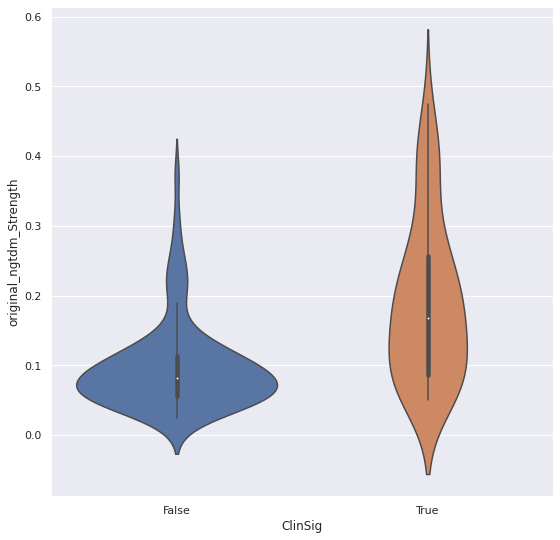

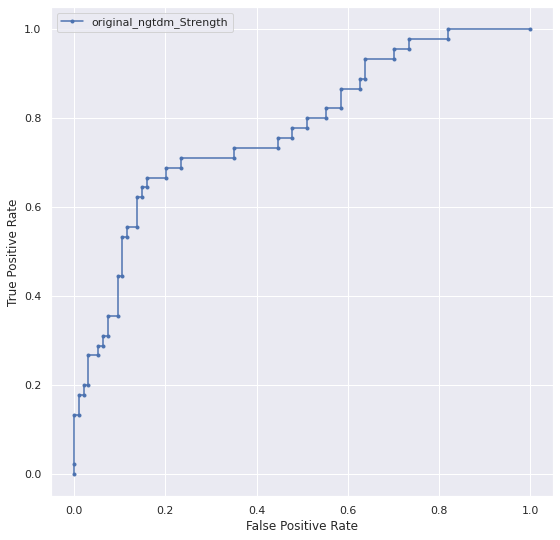

In [9]:
#@title Visualizations of discriminative power of radiomic features
dropdown = 'original_ngtdm_Strength' #@param ['squareroot_ngtdm_Strength', 'logarithm_ngtdm_Strength', 'square_gldm_GrayLevelNonUniformity', 'log-sigma-5-mm-3D_gldm_GrayLevelNonUniformity', 'wavelet-LL_ngtdm_Strength', 'wavelet-LL_gldm_GrayLevelNonUniformity', 'wavelet-LL_glrlm_GrayLevelNonUniformity', 'original_glrlm_GrayLevelNonUniformity', 'original_gldm_GrayLevelNonUniformity', 'log-sigma-3-mm-3D_gldm_GrayLevelNonUniformity', 'original_ngtdm_Strength', 'wavelet-LL_glszm_GrayLevelNonUniformity', 'log-sigma-5-mm-3D_glszm_ZoneVariance', 'original_glszm_GrayLevelNonUniformity', 'log-sigma-3-mm-3D_ngtdm_Coarseness', 'log-sigma-5-mm-3D_ngtdm_Coarseness', 'log-sigma-5-mm-3D_glszm_LargeAreaEmphasis', 'wavelet-LL_ngtdm_Busyness', 'squareroot_ngtdm_Busyness', 'logarithm_ngtdm_Coarseness']

import seaborn as sns
from matplotlib import pyplot
from sklearn.metrics import roc_curve
sns.set(rc={'figure.figsize':(9,9)})
sns.violinplot(x=Y_train, y=X_train[dropdown])

plt.figure(0)
lr_fpr, lr_tpr, _ = roc_curve(Y_train, X_train[dropdown])
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label=dropdown)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [10]:
#@title Lets count how many features are statistically significant between groups after the multiple comparisons correction
print(sum(i < 0.05 for i in corrected_p_value))

107


In [11]:
#@title Lets train a model using 1 feature for every 15 patients we have on the training set
#@markdown We will use the best features, according to the univariate analysis on the training set

num_features_model = round(X_train[dropdown].shape[0]/15)
train_df = train_auc_pvals_df.sort_values(by='p-value', ascending=True)
selected_features = train_df.index[0:num_features_model]

X_train_new = X_train[selected_features]

In [12]:
#@title Select optimization metric
#@markdown Note: We will have a deeper look at metric in the next part of the workshop
optimization_metric = "MCC" #@param ["AUC", "MCC", "Kappa","F1", "Accuracy", "Sensitivity", "Specificity", "PPV", "NPV", "BalancedAcc"]

if optimization_metric == "AUC":
    score_str = 'roc_auc'
elif optimization_metric == "MCC":
    score_str = make_scorer(matthews_corrcoef)
elif optimization_metric == "Kappa":
    score_str = make_scorer(cohen_kappa_score)
elif optimization_metric == "F1":
    score_str = 'f1'
elif optimization_metric == "Accuracy":
    score_str = 'accuracy'
elif optimization_metric == "Sensitivity":
    score_str = 'recall'
elif optimization_metric == "Specificity":
    score_str = make_scorer(recall_score, pos_label=0)
elif optimization_metric == "PPV":
    score_str = 'precision'
elif optimization_metric == "NPV":
    score_str = make_scorer(precision_score, pos_label=0)
elif optimization_metric == "BalancedAcc":
    score_str = 'balanced_accuracy'

# random_state_value = 1

score_group = {'AUC': 'roc_auc', 'MCC': make_scorer(matthews_corrcoef) ,
               'Kappa': make_scorer(cohen_kappa_score), 
               'F1': 'f1', 'Accuracy': 'accuracy', 
               'Sensitivity': 'recall', 
               'Specificity': make_scorer(recall_score, pos_label=0),
               'PPV': 'precision', 
               'NPV': make_scorer(precision_score, pos_label=0),
               'BalancedAcc': 'balanced_accuracy'}

score_refit_str = optimization_metric

In [13]:
#@title Classifier Selection

#@markdown When trying to compare and select among several classifiers, the 
#@markdown recommended approach select the best classifier method is by using 
#@markdown the nested cross-validation. This proceedure consist of an outer 
#@markdown k-fold cross-validation loop to splipt the data into training and 
#@markdown test folds, and an inner k-fold cross-validation loop on the training
#@markdown fold, as shown the figure below.

#@markdown ![](https://drive.google.com/uc?export=view&id=10IZjGrPq7xBWPslhlNPBqwb-9qx7Mevx)

#@markdown Below you can select the models to be compared (the more you select 
#@markdown the longer the execution time)

SVM_classifier = True #@param {type:"boolean"}
LogisticRegression_classifier = True #@param {type:"boolean"}
RandomForest_classifier = True #@param {type:"boolean"}
# MLP_classifier = True #@param {type:"boolean"}
NaiveBayes_classifier = True #@param {type:"boolean"}
KNN_classifier = True #@param {type:"boolean"}
GradientBoosting_classifier = True #@param {type:"boolean"}

In [14]:
#@title Run and Compare Classifiers

df_ncv_scores = pd.DataFrame(columns = ['Classifier', 'Nested-CV Mean', 'Nested-CV Std'])
if SVM_classifier:
    pipe_svc = make_pipeline(StandardScaler(),
                             #fs_method,
                             VarianceThreshold(),
                         SVC(random_state=random_state_value))

    param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

    param_grid_svc = [{'svc__C': param_range, 
                  'svc__kernel': ['linear']},
                  {'svc__C': param_range, 
                  'svc__gamma': param_range, 
                  'svc__kernel': ['rbf']}]

    gs_svc = GridSearchCV(estimator=pipe_svc, 
                      param_grid=param_grid_svc, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_scv = cross_val_score(gs_svc, X_train_new, y_train, 
                            scoring=score_str, cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['SVM'], 'Nested-CV Mean': [np.mean(scores_scv)], 'Nested-CV Std': [np.std(scores_scv)]}, columns = ['Classifier', 'Nested-CV Mean', 'Nested-CV Std'])
    df_ncv_scores = df_ncv_scores.append(df_score)
    
if LogisticRegression_classifier:
    pipe_lr = make_pipeline(StandardScaler(),
                             #fs_method,
                            VarianceThreshold(),
                        LogisticRegression(random_state=random_state_value, #penalty='elasticnet', 
                                           solver='saga'))

    param_range_lr = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

    param_range_reg_lr = np.linspace(0,1,11)

    param_range_penalty = ['l1']#, 'elasticnet']

    param_grid_lr = {'logisticregression__penalty': param_range_penalty,
                     'logisticregression__C': param_range_lr,
                    #  'logisticregression__l1_ratio': param_range_reg_lr
                     }

    gs_lr = GridSearchCV(estimator=pipe_lr, 
                      param_grid=param_grid_lr, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_lr = cross_val_score(gs_lr, X_train_new, y_train, 
                            scoring=score_str, cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['Logistic Regression'], 'Nested-CV Mean': [np.mean(scores_lr)], 'Nested-CV Std': [np.std(scores_lr)]})
    df_ncv_scores = df_ncv_scores.append(df_score)

if RandomForest_classifier:
    pipe_rf = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                             #fs_method,
                        RandomForestClassifier(n_jobs=-1, random_state=random_state_value))

    param_range_rf = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

    param_grid_rf = {'randomforestclassifier__n_estimators': param_range_rf,
                    'randomforestclassifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

    gs_rf = GridSearchCV(estimator=pipe_rf, 
                      param_grid=param_grid_rf, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_rf = cross_val_score(gs_rf, X_train_new, y_train, 
                            scoring=score_str, cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['Random Forest'], 'Nested-CV Mean': [np.mean(scores_rf)], 'Nested-CV Std': [np.std(scores_rf)]})
    df_ncv_scores = df_ncv_scores.append(df_score)

# if MLP_classifier:
#     pipe_mlp = make_pipeline(StandardScaler(),
#                              VarianceThreshold(),
#                         MLPClassifier(random_state=random_state_value, activation='adaptive'))

#     param_hidden_layer_sizes_mlp = [50, 100, 200, 500, 1000, 2000, 4000]
#     param_learnrate_mlp = [0.0001, 0.001, 0.01, 0.1]

#     param_grid_mlp = {'mlpclassifier__hidden_layer_sizes': param_hidden_layer_sizes_mlp,
#                     'mlpclassifier__activation': ['logistic', 'tanh', 'relu'],
#                     'mlpclassifier__learning_rate_init':param_learnrate_mlp}

#     gs_mlp = GridSearchCV(estimator=pipe_mlp, 
#                       param_grid=param_grid_mlp, 
#                       scoring=score_str, 
#                       refit=True,
#                       cv=2,
#                       n_jobs=-1)

#     scores_mlp = cross_val_score(gs_mlp, X_train, y_train, 
#                             scoring=score_str, cv=5)
#     print('MLP CV %s: %.3f +/- %.3f' % (score_str, np.mean(scores_mlp),
#                                           np.std(scores_mlp)))
#     df_score = pd.DataFrame(data={'Classifier': ['MLP'], 'Nested-CV Mean': [np.mean(scores_mlp)], 'Nested-CV Std': [np.std(scores_mlp)]})
#     df_ncv_scores = df_ncv_scores.append(df_score)

if NaiveBayes_classifier:
    pipe_nb = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                             #fs_method,
                        GaussianNB())

    param_grid_nb = {}

    gs_nb = GridSearchCV(estimator=pipe_nb, 
                      param_grid=param_grid_nb, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_nb = cross_val_score(gs_nb, X_train_new, y_train, 
                            scoring=score_str, cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['Naive Bayes'], 'Nested-CV Mean': [np.mean(scores_nb)], 'Nested-CV Std': [np.std(scores_nb)]})
    df_ncv_scores = df_ncv_scores.append(df_score)

if KNN_classifier:
    pipe_knn = make_pipeline(StandardScaler(),
                             VarianceThreshold(),
                             #fs_method,
                        KNeighborsClassifier(n_jobs=-1)) # random_state=random_state_value, 

    param_n_neighbors_knn = [2, 3, 4, 5, 6, 7, 8]

    param_grid_knn = {'kneighborsclassifier__n_neighbors': param_n_neighbors_knn,
                    'kneighborsclassifier__weights': ['uniform', 'distance']}

    gs_knn = GridSearchCV(estimator=pipe_knn, 
                      param_grid=param_grid_knn, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_knn = cross_val_score(gs_knn, X_train_new, y_train, 
                            scoring=score_str, cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['KNN'], 'Nested-CV Mean': [np.mean(scores_knn)], 'Nested-CV Std': [np.std(scores_knn)]})
    df_ncv_scores = df_ncv_scores.append(df_score)

if GradientBoosting_classifier:
    pipe_gb = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                             #fs_method,
                        GradientBoostingClassifier(random_state=random_state_value))

    param_range_gb = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    param_learnrate_gb = [0.0001, 0.001, 0.01, 0.1]

    param_grid_gb = {'gradientboostingclassifier__n_estimators': param_range_gb,
                    'gradientboostingclassifier__learning_rate': param_learnrate_gb}

    gs_gb = GridSearchCV(estimator=pipe_gb, 
                      param_grid=param_grid_gb, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_gb = cross_val_score(gs_gb, X_train_new, y_train, 
                            scoring=score_str, cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['Gradient Boosting'], 'Nested-CV Mean': [np.mean(scores_gb)], 'Nested-CV Std': [np.std(scores_gb)]})
    df_ncv_scores = df_ncv_scores.append(df_score)

df_ncv_scores.sort_values(by=df_ncv_scores.columns[1], ascending=False)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

,Classifier,Nested-CV Mean,Nested-CV Std
0,Random Forest,0.469546,0.107331
0,Logistic Regression,0.412088,0.132343
0,SVM,0.397232,0.114842
0,Naive Bayes,0.395039,0.210041
0,Gradient Boosting,0.362410,0.113773
0,KNN,0.351353,0.152018


In [ ]:
#@title Select classifier to train/fine-tune model

selected_model = 'LogisticRegression' #@param ['SVM', 'LogisticRegression', 'RandomForest', 'NaiveBayes', 'KNN', 'GradientBoosting']

number_folds = 5 #@param {type:"slider", min:2, max:10, step:1}

In [ ]:
#@title Train/Fine-tune selected model

if selected_model == 'SVM':
  pipe_svc = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                            #  fs_method,
                        SVC(random_state=random_state_value))

  param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

  param_grid_svc = [{'svc__C': param_range, 
                'svc__kernel': ['linear']},
                {'svc__C': param_range, 
                'svc__gamma': param_range, 
                'svc__kernel': ['rbf']}]

  gs_svc = GridSearchCV(estimator=pipe_svc, 
                    param_grid=param_grid_svc, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)

  gs = gs_svc.fit(X_train_new, y_train)
  clf_svc = gs.best_estimator_
          
elif selected_model == 'LogisticRegression':
  pipe_lr = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                            #  fs_method,
                          LogisticRegression(penalty='elasticnet', random_state=random_state_value,
                                            solver='saga'))

  param_range_lr = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

  param_l1_ratio_lr = np.linspace(0,1,11)

  param_range_penalty = ['l1']#, 'elasticnet']

  param_grid_lr = {'logisticregression__penalty': param_range_penalty,
                   'logisticregression__C': param_range_lr}#,
                  #  'logisticregression__l1_ratio': param_range_reg_lr}

  gs_lr = GridSearchCV(estimator=pipe_lr, 
                    param_grid=param_grid_lr, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)

  gs = gs_lr.fit(X_train_new, y_train)
  clf_lr = gs.best_estimator_

elif selected_model == 'RandomForest':
  pipe_rf = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                            #  fs_method,
                        RandomForestClassifier(n_jobs=-1, random_state=random_state_value))

  param_range_rf = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

  param_grid_rf = {'randomforestclassifier__n_estimators': param_range_rf,
                  'randomforestclassifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

  gs_rf = GridSearchCV(estimator=pipe_rf, 
                    param_grid=param_grid_rf, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)
  gs = gs_rf.fit(X_train_new, y_train)
  clf_rf = gs.best_estimator_

elif selected_model == 'MLP':
  pipe_mlp = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                            #  fs_method,
                        MLPClassifier(random_state=random_state_value, activation='adaptive'))

  param_hidden_layer_sizes_mlp = [50, 100, 200, 500, 1000, 2000, 4000]
  param_learnrate_mlp = [0.0001, 0.001, 0.01, 0.1]

  param_grid_mlp = {'mlpclassifier__hidden_layer_sizes': param_hidden_layer_sizes_mlp,
                  'mlpclassifier__activation': ['logistic', 'tanh', 'relu'],
                  'mlpclassifier__learning_rate_init':param_learnrate_mlp}

  gs_mlp = GridSearchCV(estimator=pipe_mlp, 
                    param_grid=param_grid_mlp, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)
  gs = gs_mlp.fit(X_train_new, y_train)
  clf_mlp = gs.best_estimator_

elif selected_model == 'NaiveBayes':
  pipe_nb = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                            #  fs_method,
                          GaussianNB())

  param_grid_nb = {}

  gs_nb = GridSearchCV(estimator=pipe_nb, 
                    param_grid=param_grid_nb, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)
  gs = gs_nb.fit(X_train_new, y_train)
  clf_nb = gs.best_estimator_
  
elif selected_model == 'KNN':
  pipe_knn = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                            #  fs_method,
                        KNeighborsClassifier(n_jobs=-1)) # random_state=random_state_value, 

  param_n_neighbors_knn = [2, 3, 4, 5, 6, 7, 8]

  param_grid_knn = {'kneighborsclassifier__n_neighbors': param_n_neighbors_knn,
                  'kneighborsclassifier__weights': ['uniform', 'distance']}

  gs_knn = GridSearchCV(estimator=pipe_knn, 
                    param_grid=param_grid_knn, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)
  gs = gs_knn.fit(X_train_new, y_train)
  clf_knn = gs.best_estimator_
  
elif selected_model == 'GradientBoosting':
  pipe_gb = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                            #  fs_method,
                        GradientBoostingClassifier(random_state=random_state_value))

  param_range_gb = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
  param_learnrate_gb = [0.0001, 0.001, 0.01, 0.1]

  param_grid_gb = {'gradientboostingclassifier__n_estimators': param_range_gb,
                  'gradientboostingclassifier__learning_rate': param_learnrate_gb}

  gs_gb = GridSearchCV(estimator=pipe_gb, 
                    param_grid=param_grid_gb, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)
  gs = gs_gb.fit(X_train_new, y_train)
  clf_gb = gs.best_estimator_

print(gs.best_params_)
for key in score_group:
    if len(gs.cv_results_['std_test_'+key][gs.cv_results_['rank_test_'+key]==1])>1:
        print('CV %s: %.3f +/- %.3f' % (key,
                                        gs.cv_results_['mean_test_'+key][gs.cv_results_['rank_test_'+key]==1][0],
                                        gs.cv_results_['std_test_'+key][gs.cv_results_['rank_test_'+key]==1][0]))
    else:
        print('CV %s: %.3f +/- %.3f' % (key,
                                        gs.cv_results_['mean_test_'+key][gs.cv_results_['rank_test_'+key]==1],
                                        gs.cv_results_['std_test_'+key][gs.cv_results_['rank_test_'+key]==1]))


{'logisticregression__C': 10.0, 'logisticregression__penalty': 'l1'}
CV AUC: 0.775 +/- 0.106
CV MCC: 0.450 +/- 0.230
CV Kappa: 0.414 +/- 0.237
CV F1: 0.547 +/- 0.203
CV Accuracy: 0.770 +/- 0.094
CV Sensitivity: 0.470 +/- 0.230
CV Specificity: 1.000 +/- 0.000
CV PPV: 0.765 +/- 0.215
CV NPV: 0.787 +/- 0.085
CV BalancedAcc: 0.692 +/- 0.117


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


# Assess Model performance on the held-out test dataset

In [ ]:
#@title Obtain the univariate performance of the best 5 features on the test set 
#@markdown We will do this using the cut-off thresholds of these features on the
#@markdown training set

train_metrics_df = train_auc_pvals_corrected_df.sort_values(by='corrected p-value', ascending=True)
train_metrics_df.head()

auc_test_list, sens_test_list, spec_test_list = ([] for i in range(3))
for indx in range(5):
  feature_name = train_metrics_df.index[indx]
  if train_metrics_df.iloc[indx]['Pos.vs.Neg.'] == '>':
    fpr, tpr, thresholds = metrics.roc_curve(y_test, X_test[feature_name], pos_label=1)
    pred = np.zeros(X_test[feature_name].shape)
    pred[X_test[feature_name] >= train_metrics_df.iloc[indx]['Cutoff-Threshold']] = 1
    pred[X_test[feature_name] < train_metrics_df.iloc[indx]['Cutoff-Threshold']] = 0
  else:
    fpr, tpr, thresholds = metrics.roc_curve(y_test, X_test[feature_name], pos_label=0)
    pred[X_test[feature_name] < train_metrics_df.iloc[indx]['Cutoff-Threshold']] = 1
    pred[X_test[feature_name] >= train_metrics_df.iloc[indx]['Cutoff-Threshold']] = 0
  auc = metrics.auc(fpr, tpr)
  tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
  sensitivity = tp / (tp+fn)
  specificity = tn / (tn+fp)
  auc_test_list.append(auc)
  sens_test_list.append(sensitivity)
  spec_test_list.append(specificity)

test_auc_pvals_df = pd.DataFrame(list(zip(auc_test_list, 
                                           sens_test_list, spec_test_list)), 
                                  index = train_metrics_df.index[0:5],
                                  columns =['AUC', 'Sensitivity', 
                                            'Specificity'])
test_auc_pvals_df


,AUC,Sensitivity,Specificity
squareroot_ngtdm_Strength,0.71375,0.55,0.650
logarithm_ngtdm_Strength,0.73375,0.60,0.700
square_gldm_GrayLevelNonUniformity,0.71875,0.70,0.625
log-sigma-5-mm-3D_gldm_GrayLevelNonUniformity,0.76375,0.70,0.700
wavelet-LL_ngtdm_Strength,0.66750,0.55,0.600


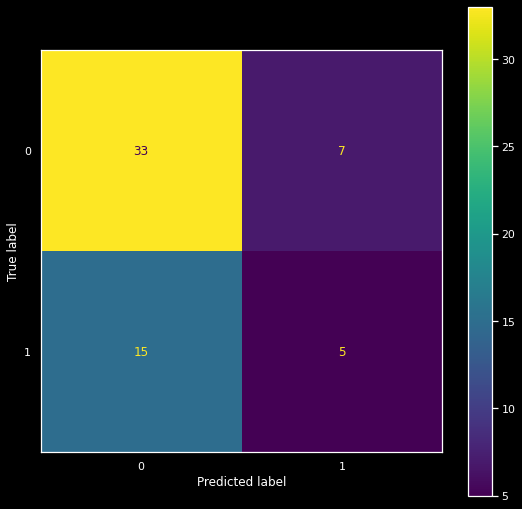

In [ ]:
#@title Plot Confusion Matrix of tuned model on held-out test dataset prediction
import matplotlib.pyplot as plt
fig = plt.figure()
rect = fig.patch
rect.set_facecolor('black')
ax = fig.add_subplot(111)
ax.grid(b=False)
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plot_confusion_matrix(gs, X_test[selected_features], y_test, ax=ax)  # doctest: +SKIP

fg_color = 'white'  
# Get the images on an axis
im = ax.images        
# Assume colorbar was plotted last one plotted last
cb = im[-1].colorbar   
# COLORBAR
# set colorbar tick color
cb.ax.yaxis.set_tick_params(color=fg_color)

# set colorbar edgecolor 
cb.outline.set_edgecolor(fg_color)
cbytick_obj = plt.getp(cb.ax.axes, 'yticklabels')                #tricky
plt.setp(cbytick_obj, color='white')
plt.show()

In [ ]:
#@title Obtain performance metrics of model on the held-out test set
clf = gs
print('AUC: %.3f' % (roc_auc_score(y_test, clf.predict(X_test[selected_features]))))
print('MCC: %.3f' % (matthews_corrcoef(y_test, clf.predict(X_test[selected_features]))))
print('Kappa: %.3f' % (cohen_kappa_score(y_test, clf.predict(X_test[selected_features]))))
print('F1: %.3f' % (f1_score(y_test, clf.predict(X_test[selected_features]))))
print('Accuracy: %.3f' % (accuracy_score(y_test, clf.predict(X_test[selected_features]))))
print('Sensitivity: %.3f' % (recall_score(y_test, clf.predict(X_test[selected_features]))))
print('Specificity: %.3f' % (recall_score(y_test, clf.predict(X_test[selected_features]), pos_label=0)))
print('PPV: %.3f' % (precision_score(y_test, clf.predict(X_test[selected_features]))))
print('NPV: %.3f' % (precision_score(y_test, clf.predict(X_test[selected_features]), pos_label=0)))
print('BalancedAcc: %.3f\n\n' % (balanced_accuracy_score(y_test, clf.predict(X_test[selected_features]))))

AUC: 0.537
MCC: 0.088
Kappa: 0.083
F1: 0.312
Accuracy: 0.633
Sensitivity: 0.250
Specificity: 0.825
PPV: 0.417
NPV: 0.688
BalancedAcc: 0.537




# Additional Notes and Resources

- F1-score vs Balanced Accuracy - https://stats.stackexchange.com/questions/49579/balanced-accuracy-vs-f-1-score


> 1.   If N >> P, F1-score is a better.
> 2.   If P >> N, Balanced Accuracy is better.
> 
> N - number of cases in the negative class;
> P - number of cases in the positive class

- Upsampling/Downsampling - https://stats.stackexchange.com/questions/222558/classification-evaluation-metrics-for-highly-imbalanced-data

> "For up-/downsampling: I think there is no canonical answer to "if those are required". They are more one way of adapting your problem. Technically: yes, you could use them, but use them with care, especially upsampling (you might end up creating unrealistic samples without noticing it) - and be aware that changing the frequency of samples of both classes to something not realistic "in the wild" might have negative effects on prediction performance as well. At least the final, held-out test set should reflect the real-life frequency of samples again. Bottom line: I've seen both cases where doing and not doing up-/or downsampling resulted in the better final outcomes, so this is something you might need to try out (but don't manipulate your test set(s)!)."

- The advantages of the Matthews correlation coefficient (MCC) over F1 score and accuracy in binary classification evaluation 
> https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7 

- Why Cohen’s Kappa should be avoided as performance measure in classification 
> https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0222916

- How to chose your classifier from a set of possible options:
> - Raschka S, Mirjalili V. **Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow 2**. 2019. Packt Publishing.
> - Varma S, Simon R. **Bias in error estimation when using cross-validation for model selection**. BMC bioinformatics. 2006 Dec 1;7(1):91.